In [1]:
# Import the appropriate packages for the project
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from nba_api.stats.endpoints import shotchartdetail
import json
import math
import colorcet as cc
from statsmodels.stats.proportion import proportions_ztest
from nba_api.stats.endpoints import leagueleaders
from sklearn import linear_model

# NBA Shot Analysis Project

## Introduction

The way that the NBA game is played has changed drastically in a very short period of time, and it does not appear to be stopping anytime soon. In 1979 the NBA introduced a line 23.75 feet from the hoop (except for in the corners where it is 22 feet away) called the “Three Point Line”, where made shots are worth 3 points instead of 2. Not much changed at first, because most players were not used to shooting from far out. It wasn't until the 1986-87 NBA season that the league as a whole made more than 100 3-pointers in a single season. As the 3-point shot became more accepted it gave increased value to players that could shoot from deep, but until recently these players were seen as specialists. Most of these players never became legit superstars. If you look back at a time as recent as the 90s and early 2000s, even the best guards (guards tend to smaller more athletic and better shooters) like Michael Jordan weren’t shooting very many 3-point shots. For the most part, they preferred taking mid-range shots and layups/dunks. For most of NBA history the mid-range shot was a staple of many players games, but recently these shots have been deemed inefficient. This is because 2-point shots between 6 and 24 feet tend to be made about 40-45% of the time. However, when players move a couple feet back (beyond the 3-point line) the percentage only drops to around 35-40%. This is important, since 3-point shots are worth an extra point compared to 2-point shots, so they can be converted at a lower rate and still generate more points per shot.

Over the last 5 season the percentage of 3-point shots attempted increased at a higher rate than ever before, and over the past 10 years the percentage of mid-range shots attempted in NBA games has dropped from 31% in the 2010-11 season to just 13% last season. Meanwhile the percentage of 3-point shots attempted has jumped up from 22% in 2010-11 to 39% last season. This made us question, what makes 3-point shots so much more appealing than mid-range shots, and how much has this change in philosophy really changed the game over the past 10 years. This project attempts to answer these questions by using shot location and shot type statistics from the 2020-21 and 2010-11 NBA seasons. We attempt to find what statistical advantage there is to shooting more 3 pointers, if any, and use visualizations and statistics to see how much the NBA game has changed from 2010 to 2020. 

## Finding and Reading in Data

We decided to use an NBA statistics API for this project, because it allows us to use a variety of different statistics in our analysis instead of being bound by the limited statistics that would be in any downloadable data source. The data we are using for this project comes from the nba_api, which is the API client for the NBA's official stats.nba.com and it can be queried to find nearly any imaginable basketball statistics from any season, for any team or player. One of the downsides to using this API is that it is largely undocumented and can be difficult to find how to request certain statistics from the API. However, there are many people on GitHub and other coding websites that have provided documentation and even created a package to make it easier to use.

Using the information that we found online we were able to query the API to read in shot data for every shot attempted during the 2020-21 and 2010-11 NBA regular seasons. We then converted the data from both of those seasons into pandas dataframes so that we can easily run analyses on them. We also converted both of the dataframes to .CSV files so that this project can be reproducible without having to use the API.

In [2]:
# Query the nba_api for the data on all the shots attempted during the 2020-21 NBA regular season
response = shotchartdetail.ShotChartDetail(
	context_measure_simple='FGA',
	team_id=0,
	player_id=0,
	season_nullable='2020-21',
	season_type_all_star='Regular Season'
)

content = json.loads(response.get_json())

In [3]:
# transform contents into dataframe, shots_df, that has the shot data for 2020-21
results = content['resultSets'][0]
headers = results['headers']
rows = results['rowSet']
shots_df = pd.DataFrame(rows)
shots_df.columns = headers

In [4]:
# Query the nba_api for the data on all the shots attempted during the 2010-11 NBA regular season
response = shotchartdetail.ShotChartDetail(
	context_measure_simple='FGA',
	team_id=0,
	player_id=0,
	season_nullable='2010-11',
	season_type_all_star='Regular Season'
)

content = json.loads(response.get_json())

In [5]:
# transform contents into dataframe, shots_df_10, that has the shot data for 2010-11
results = content['resultSets'][0]
headers = results['headers']
rows = results['rowSet']
shots_df_10 = pd.DataFrame(rows)
shots_df_10.columns = headers

In [9]:
# Save the dataframes as CSV files
shots_df.to_csv('Data/shots.csv', index = False)
shots_df_10.to_csv('Data/shots_10.csv', index = False)

## Transforming the Data

In order for us to be able to do all of the analysis that we wanted to do with the data that we got from the API, we first had to work on some data transformations. The first thing that we added to the data was a year column to both the 2010 and 2020 shot dataframes. We did this so that the years would be distinguishable, if we ever wanted to append both of the dataframes together. The next data transformation that we did was probably the hardest part of the project and that was creating shot zones. It was difficult, because to make the shot zones like we wanted we needed to know the angle that shot was taken relative to the backboard. To do this we first had to create a function that determines and returns the angle when given 3 points. We then used that function in another function that determines the shot angle of each shot and creates a new column in each of the dataframes with these shot angles. Lastly, we used these newly determined shot angles and the pre-existing shot distance data to create a function that sorted each shot into one of 27 distinct shot zones, through a long series of if and elif statements. Even though creating these shot zones was a lot of work, it ended up dramatically helping us look at scoring efficiency from different parts of the basketball court. The last piece of data transformation that we did was to add a column with points per shot to each dataframe. This column very simply just added a 3 to the row for made 3-point shots, a 2 for made 2-point shots, and a 0 for missed shots. This column was made so that we could easily find the average points per shot for a large group of shots. Once we finished our main data transformations we moved onto doing a bit of Exploratory Data Analysis.

In [10]:
# Create a new column 'year' in both of the dataframes that has the year that the shot is from
shots_df['year'] = '2020-21'
shots_df_10['year'] = '2010-11'

In [13]:
# Create a function, getAngle, that can determine the angle when given 3 points
# This function will help us determine shot angles
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang

In [14]:
# Create a function, shot_angle, that determines the angle that each shot was taken relative to the backboard 
def shot_angle(df):
    # Initialize an empty list shot_angle
    shot_angle = []
    # Use a for loop to loop over all the rows in the dataframe
    for i in range(0, len(df['LOC_X'])):
        # Use the getAngle function and the shot locations from the dataframe to calculate the shot angle of 
        # each shot and append that value to that shot_angle list
        shot_angle.append(getAngle((250, 0), (0, 0), (df.loc[i, 'LOC_X'], df.loc[i, 'LOC_Y'])))
    # Create a new column in the dataframe, shot_angle, and fill it with the values from the shot_angle list
    df['shot_angle'] = shot_angle

# Run the shot_angle function on both shots_df and shots_df_10
shot_angle(shots_df)
shot_angle(shots_df_10)

In [15]:
# Create a function, shot_zone, that seperates the court into 27 shot zones and groups all the shots taken in 
# each zone together
def shot_zone(df):
    # Initialize an empty list, shot_zone
    shot_zone = []
    # Use a for loop to loop over all the rows in the dataframe
    for i in range(0, len(df['SHOT_DISTANCE'])):
        # Use if, elif, and else statements to seperate the shots into those taken with 6ft, between 6-15ft, 
        # between 15ft and the 3pt line, and beyond the 3pt line.
        if df.loc[i, 'SHOT_DISTANCE'] < 6:
            # Use if and elif statements to sort shots into one of the 6 shot zones within 6ft based upon the 
            # shot angle of the shot and append the number of the shot zone to the shot_zone list
            if df.loc[i, 'shot_angle'] < 0:
                shot_zone.append(0)
            elif df.loc[i, 'shot_angle'] >= 0 and df.loc[i, 'shot_angle'] <= 36:
                shot_zone.append(1)
            elif df.loc[i, 'shot_angle'] > 36 and df.loc[i, 'shot_angle'] <= 72:
                shot_zone.append(2)
            elif df.loc[i, 'shot_angle'] > 72 and df.loc[i, 'shot_angle'] <= 108:
                shot_zone.append(3)
            elif df.loc[i, 'shot_angle'] > 108 and df.loc[i, 'shot_angle'] <= 144:
                shot_zone.append(4)
            elif df.loc[i, 'shot_angle'] > 144 and df.loc[i, 'shot_angle'] <= 180:
                shot_zone.append(5)
        elif df.loc[i, 'SHOT_DISTANCE'] in range(6, 15):
            # Use if and elif statements to sort shots into one of the 7 shot zones between 6-15ft based upon the 
            # shot angle of the shot and append the number of the shot zone to the shot_zone list
            if df.loc[i, 'shot_angle'] >= -90  and df.loc[i, 'shot_angle'] < 0:
                shot_zone.append(6)
            elif df.loc[i, 'shot_angle'] >= 0 and df.loc[i, 'shot_angle'] <= 36:
                shot_zone.append(7)
            elif df.loc[i, 'shot_angle'] > 36 and df.loc[i, 'shot_angle'] <= 72:
                shot_zone.append(8)
            elif df.loc[i, 'shot_angle'] > 72 and df.loc[i, 'shot_angle'] <= 108:
                shot_zone.append(9)
            elif df.loc[i, 'shot_angle'] > 108 and df.loc[i, 'shot_angle'] <= 144:
                shot_zone.append(10)
            elif df.loc[i, 'shot_angle'] > 144 and df.loc[i, 'shot_angle'] <= 180:
                shot_zone.append(11)
            elif df.loc[i, 'shot_angle'] < -90:
                shot_zone.append(12)
        elif df.loc[i, 'SHOT_DISTANCE'] in range(15, 24) and df.loc[i, 'SHOT_TYPE'] == '2PT Field Goal':
            # Use if and elif statements to sort shots into one of the 7 shot zones between 15ft and the 3pt line
            # based upon the shot angle of the shot and append the number of the shot zone to the shot_zone list
            if df.loc[i, 'shot_angle'] >= -90  and df.loc[i, 'shot_angle'] < 0:
                shot_zone.append(13)
            elif df.loc[i, 'shot_angle'] >= 0 and df.loc[i, 'shot_angle'] <= 36:
                shot_zone.append(14)
            elif df.loc[i, 'shot_angle'] > 36 and df.loc[i, 'shot_angle'] <= 72:
                shot_zone.append(15)
            elif df.loc[i, 'shot_angle'] > 72 and df.loc[i, 'shot_angle'] <= 108:
                shot_zone.append(16)
            elif df.loc[i, 'shot_angle'] > 108 and df.loc[i, 'shot_angle'] <= 144:
                shot_zone.append(17)
            elif df.loc[i, 'shot_angle'] > 144 and df.loc[i, 'shot_angle'] <= 180:
                shot_zone.append(18)
            elif df.loc[i, 'shot_angle'] < -90:
                shot_zone.append(19)
        else:
            # Use if and elif statements to sort shots into one of the 7 shot zones beyond the 3pt linebased upon 
            # the shot angle of the shot and append the number of the shot zone to the shot_zone list
            if df.loc[i, 'shot_angle'] >= -90  and df.loc[i, 'shot_angle'] < 0:
                shot_zone.append(20)
            elif df.loc[i, 'shot_angle'] >= 0 and df.loc[i, 'shot_angle'] <= 36:
                shot_zone.append(21)
            elif df.loc[i, 'shot_angle'] > 36 and df.loc[i, 'shot_angle'] <= 72:
                shot_zone.append(22)
            elif df.loc[i, 'shot_angle'] > 72 and df.loc[i, 'shot_angle'] <= 108:
                shot_zone.append(23)
            elif df.loc[i, 'shot_angle'] > 108 and df.loc[i, 'shot_angle'] <= 144:
                shot_zone.append(24)
            elif df.loc[i, 'shot_angle'] > 144 and df.loc[i, 'shot_angle'] <= 180:
                shot_zone.append(25)
            elif df.loc[i, 'shot_angle'] < -90:
                shot_zone.append(26)
    # Create a new column in the dataframe, shot_zone, and fill it with the values from the shot_zone list
    df['shot_zone'] = shot_zone

# Run the shot_zone function on both shots_df and shots_df_10
shot_zone(shots_df)
shot_zone(shots_df_10)

In [11]:
# Create a function, points_per_shot, that calculates the points scored on each shot and adds that value to the dataframe
def points_per_shot(df):
    # Initialize an empty list, pps
    pps = []
    # Use a for loop to loop over all the rows in the dataframe
    for i in range(0, len(df['SHOT_TYPE'])):
        # Use an if statement to sort for just 2pt shots
        if df.loc[i, 'SHOT_TYPE'] == '2PT Field Goal':
            # Use another if statement to check if the shot was made
            if df.loc[i, 'SHOT_MADE_FLAG'] == 1:
                # Append 2 to the list if the shot was made
                pps.append(2)
            else:
                # Append 0 to the list if the shot was missed
                pps.append(0) 
        # Use an else statement to get the 3pt shots        
        else:
            # Use an if statement to check if the shot was made
            if df.loc[i, 'SHOT_MADE_FLAG'] == 1:
                # Append 3 to the list if the shot was made
                pps.append(3)
            else:
                # Append 0 to the list if the shot was missed
                pps.append(0) 
    # Create a new column in the dataframe, points_per_shot, and fill it with the values from the pps list
    df['points_per_shot'] = pps

# Run the points_per_shot function on both shots_df and shots_df_10
points_per_shot(shots_df)
points_per_shot(shots_df_10)

## Exploratory Data Analysis

For our exploratory data analysis, we just wanted to run a couple of statistics and create a few simple visualizations. The first analysis that we ran involved using the newly created points per shot column, and using it to find the average points per shot in both the 2020-21 and 2010-11 NBA seasons. We wanted to calculate this statistic, because we wanted to know if the overall efficiency of scoring had changed in the past 10 seasons. We found that 2020-21 had an average points per shot around 0.08 higher than in 2010-11. While this difference may seem small, it really is quite significant when you realize that around 90 shots are taken on average in an NBA game. This means that around 7 points more are being scored in games in 2020-21 compared to 2010-11 just because of more efficient scoring.

In [17]:
# Print the average points per shot for the 2020-21 and 2010-11 NBA seasons
print('The average points per shot in 2020-21 is:', np.mean(shots_df['points_per_shot']).round(4))
print('The average points per shot in 2010-11 is:', np.mean(shots_df_10['points_per_shot']).round(4))

The average points per shot in 2020-21 is: 1.0758
The average points per shot in 2010-11 is: 0.9967


Next, we used the point per shot column again, because we wanted to see how much the distance of shots effected their efficiency and if there was any large differency in these efficencies between the 2020-21 and 2010-11 NBA seasons. What we found is that shots taken within 8ft and greater than 24ft produced the greatest points per shot and points per shot in the 4 different shot ranges remained similar between the 2 seasons.

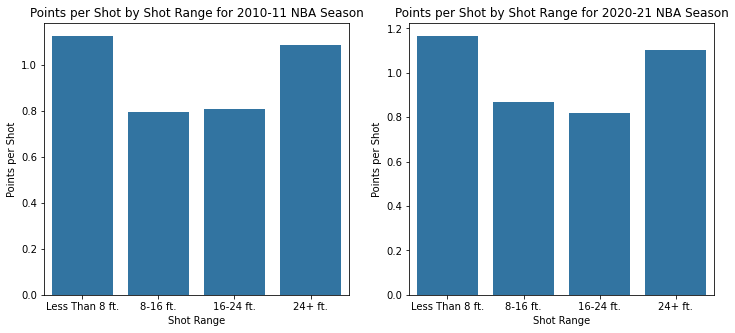

In [19]:
# Create barcharts showing the points per shot by shot range for both the 2020-21 and 2010-11 NBA seasons
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.barplot(x = 'SHOT_ZONE_RANGE', y = 'points_per_shot', data = shots_df_10, ci = None, order = ['Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.'], color = 'tab:blue', ax=ax[0])
# Give the plot a title and axis labels
ax[0].title.set_text("Points per Shot by Shot Range for 2010-11 NBA Season")
ax[0].set_xlabel("Shot Range")
ax[0].set_ylabel("Points per Shot")

sns.barplot(x = 'SHOT_ZONE_RANGE', y = 'points_per_shot', data = shots_df, ci = None, order = ['Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.'], color = 'tab:blue', ax=ax[1])
# Give the plot a title and axis labels
ax[1].title.set_text("Points per Shot by Shot Range for 2020-21 NBA Season")
ax[1].set_xlabel("Shot Range")
ax[1].set_ylabel("Points per Shot")

plt.show()

Then, we wanted to plot histograms showing the distribution of shots by shot distance for the 2020-21 and 2010-11 NBA seasons to see if there was any large difference. We found that shots between 12ft and the 3-point line decreased tremendously in 2020-21 and shots beyond the 3-point line increased, when compared to 2010-11.

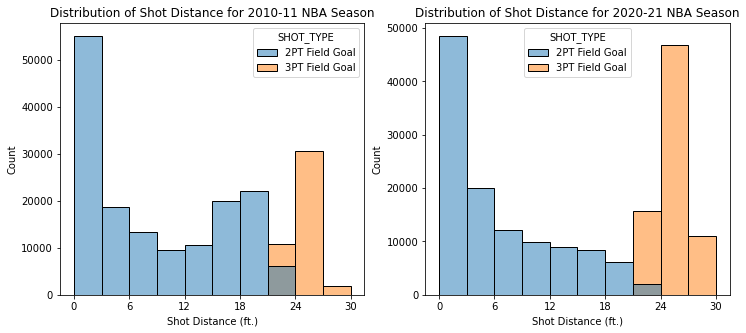

In [18]:
# Create 2 dataframes normal_shots_df and normal_shots_df_10 that filter for shots that were taken with 30ft
normal_shots_df = shots_df[shots_df.SHOT_DISTANCE <= 30]
normal_shots_df_10 = shots_df_10[shots_df_10.SHOT_DISTANCE <= 30]

# Create a histogram showing the shot distribution by shot distance for the 2020-21 and 2010-11 NBA seasons
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].title.set_text("Distribution of Shot Distance for 2010-11 NBA Season")
ax[0].set_xlabel("Shot Distance (ft.)")
ax[0].set_xticks(range(0, 31, 6))
sns.histplot(x = 'SHOT_DISTANCE', data=normal_shots_df_10, bins=10, hue='SHOT_TYPE', ax=ax[0])

ax[1].title.set_text("Distribution of Shot Distance for 2020-21 NBA Season")
ax[1].set_xlabel("Shot Distance (ft.)")
ax[1].set_xticks(range(0, 31, 6))
sns.histplot(x = 'SHOT_DISTANCE', data=normal_shots_df, bins=10, hue='SHOT_TYPE', ax=ax[1])

plt.show()

## Shot Chart Analysis 

During our exploratory data analysis, we noticed that 3-point shooting has spiked up and mid-range shots are down considerably. However, the efficiency from different ranges has seemed to stay fairly consistent from 2010-11 to 2020-21 despite a large disparity in the number of shots taken from each distance. To explore this farther, we wanted to make some shot charts and use the shot zones that we made earlier. We thought that doing some of our analysis in the form of shot charts would make the data easier to visualize and make some clear conclusions with. 

First, we needed a way to draw the court on the background of our shot charts. Luckily, we were able to find a function on the internet that only needed a few minor tweaks to work with our data.

In [7]:
from matplotlib.patches import Circle, Rectangle, Arc

# Create a function, draw_court, that will draw a court on the background of plots.
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [22]:
# Create a palette to use for the shot charts
palette = sns.color_palette('Spectral', as_cmap=True)

We first made a couple of simple shot charts. On a shot chart like this one, each point on the visualization correlates to the spot on the court where an actual shot was taken. This shart chart is for the 2010-11 NBA season, and what we found is that the shots were mostly concentrated inside the 3-point line with a large amount of mid-range shots.

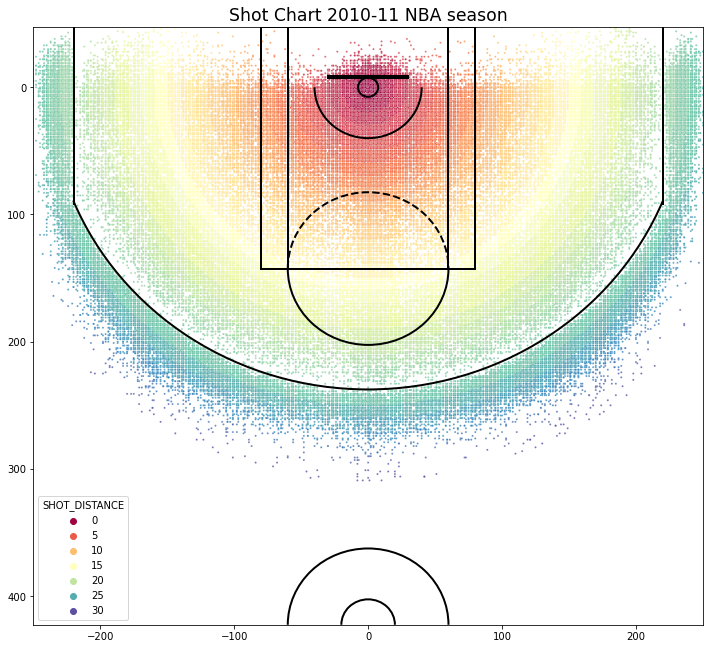

In [24]:
# Create a shot chart for the 2010-11 NBA season
plt.figure(figsize=(12,11))
sns.scatterplot(x = 'LOC_X', y = 'LOC_Y', data = normal_shots_df_10, alpha = 0.8, hue = normal_shots_df_10.SHOT_DISTANCE, palette = palette, s = 4)
# Draw the court in the background with draw_court()
draw_court()

# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along the y axis from bottom to top in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
plt.xlabel('')
plt.ylabel('')
plt.tick_params(labelbottom='off', labelleft='off')

# Add a title
plt.title('Shot Chart 2010-11 NBA season', size='xx-large')

plt.show()

Now to compare 2010-11 with 2020-21 we made a shot chart for the 2020-21 NBA season. We found that a clear divide begins to occur. Players started attempting more than shots beyond the 3-point line and the shots attempted inside the 3-point line are now more condensed around the basket.

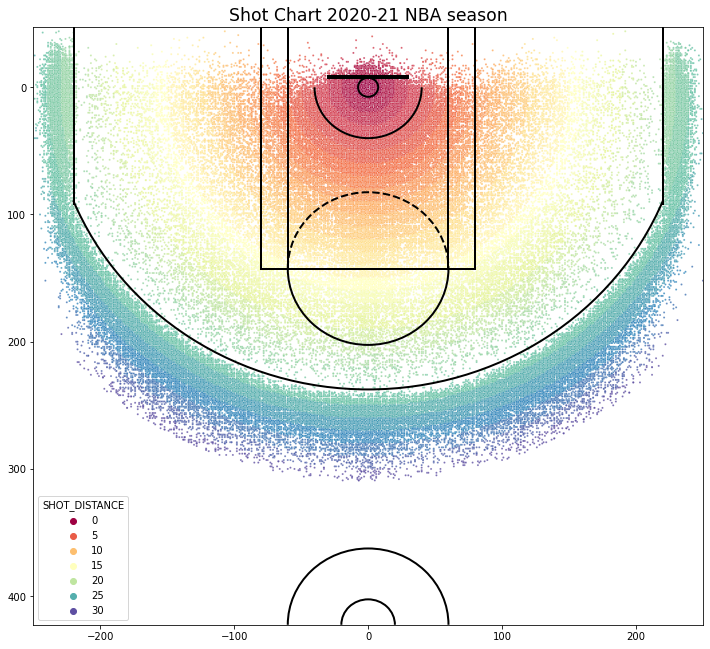

In [23]:
# Create a shot chart for the 2020-21 NBA season
plt.figure(figsize=(12,11))
sns.scatterplot(x = 'LOC_X', y = 'LOC_Y', data = normal_shots_df, alpha = 0.8, hue = normal_shots_df.SHOT_DISTANCE, palette = palette, s = 4)
# Draw the court in the background with draw_court()
draw_court()
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along the y axis from bottom to top in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
plt.xlabel('')
plt.ylabel('')
plt.tick_params(labelbottom='off', labelleft='off')

# Add a title
plt.title('Shot Chart 2020-21 NBA season', size='xx-large')

plt.show()

In [ ]:
# Create color palette for shot zone chart
palette_cc = sns.color_palette(cc.glasbey_cool, n_colors = 27)

Next, we wanted to include the shot zones in our shot chart analysis. We first wanted to see how they looked on a chart so we took the 2010-11 shot chart and colored it by shot zone. There are 27 distinct shot zones.

6 within 6ft of the basket (0-6)​

7 between 6-15ft of the basket (6-12)​

7 between 15ft and the 3-point line (13-19)​

7 beyond the 3-point line (20-26)

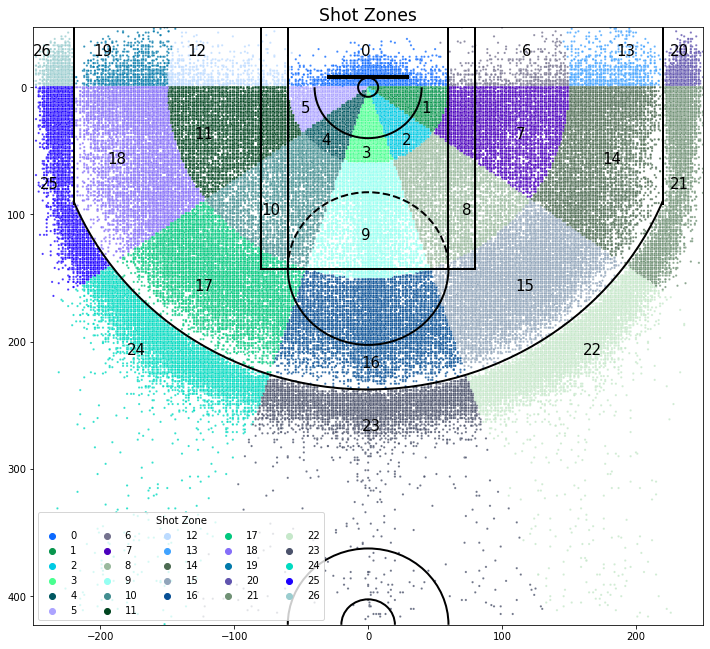

In [ ]:
# Create a shot chart that is colored by shot zone 
plt.figure(figsize=(12,11))
sns.scatterplot(x = 'LOC_X', y = 'LOC_Y', data = shots_df_10, alpha = 0.8, hue = shots_df_10.shot_zone, palette = palette_cc, s = 5)
# Draw the court in the background with draw_court()
draw_court()

# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along the y axis from bottom to top in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
plt.xlabel('')
plt.ylabel('')
plt.tick_params(labelbottom='off', labelleft='off')

# Annotate the number of the shot zone
plt.annotate(0, (-5, -25), fontsize = 15)
plt.annotate(1, (40, 20), fontsize = 15)
plt.annotate(2, (25, 45), fontsize = 15)
plt.annotate(3, (-5, 55), fontsize = 15)
plt.annotate(4, (-35, 45), fontsize = 15)
plt.annotate(5, (-50, 20), fontsize = 15)
plt.annotate(6, (115, -25), fontsize = 15)
plt.annotate(7, (110, 40), fontsize = 15)
plt.annotate(8, (70, 100), fontsize = 15)
plt.annotate(9, (-5, 120), fontsize = 15)
plt.annotate(10, (-80, 100), fontsize = 15)
plt.annotate(11, (-130, 40), fontsize = 15)
plt.annotate(12, (-135, -25), fontsize = 15)
plt.annotate(13, (185, -25), fontsize = 15)
plt.annotate(14, (175, 60), fontsize = 15)
plt.annotate(15, (110, 160), fontsize = 15)
plt.annotate(16, (-5, 220), fontsize = 15)
plt.annotate(17, (-130, 160), fontsize = 15)
plt.annotate(18, (-195, 60), fontsize = 15)
plt.annotate(19, (-205, -25), fontsize = 15)
plt.annotate(20, (225, -25), fontsize = 15)
plt.annotate(21, (225, 80), fontsize = 15)
plt.annotate(22, (160, 210), fontsize = 15)
plt.annotate(23, (-5, 270), fontsize = 15)
plt.annotate(24, (-180, 210), fontsize = 15)
plt.annotate(25, (-245, 80), fontsize = 15)
plt.annotate(26, (-250, -25), fontsize = 15)

# Add a legend to the plot
plt.legend(ncol = 5, loc = 'lower left', title = 'Shot Zone')
# Add a title to the plot
plt.title('Shot Zones', size='xx-large')

plt.show()

In [ ]:
# Find the number of shots taken in each shot zone by using groupby and .size()
num_shots_by_zone = shots_df.groupby('shot_zone').size()
num_shots_by_zone_10 = shots_df_10.groupby('shot_zone').size()

In [ ]:
# Create a color palette that colors each sector of shot zones the same color
palette_num_shots_10 = sns.color_palette(['royalblue', 'maroon', 'darkorange', 'yellow', 'darkgreen', 'indigo', 'lightblue', 'indianred', 'sandybrown', 'goldenrod', 'mediumseagreen', 'mediumpurple', 'lightblue', 'powderblue', 'firebrick', 'darkorange', 'gold', 'green', 'rebeccapurple', 'powderblue', 'skyblue', 'salmon', 'orange', 'goldenrod', 'darkgreen', 'mediumpurple', 'skyblue'], n_colors=27)

Next, we made a shot chart colored by the number of shots taken in each shot zone and annotated with the number of shots taken in each shot zone. First, we did this for the 2010-11 NBA season. The nice thing about dividing the shot chart into zones is that it allows us to look more closely at different areas on the court. For the 2010-11 season noticed that the distribution of shots is more evenly spread in all zones. ​We also saw a large number of shots attempted in the deep mid-range(15ft to the 3-point line) zones.​

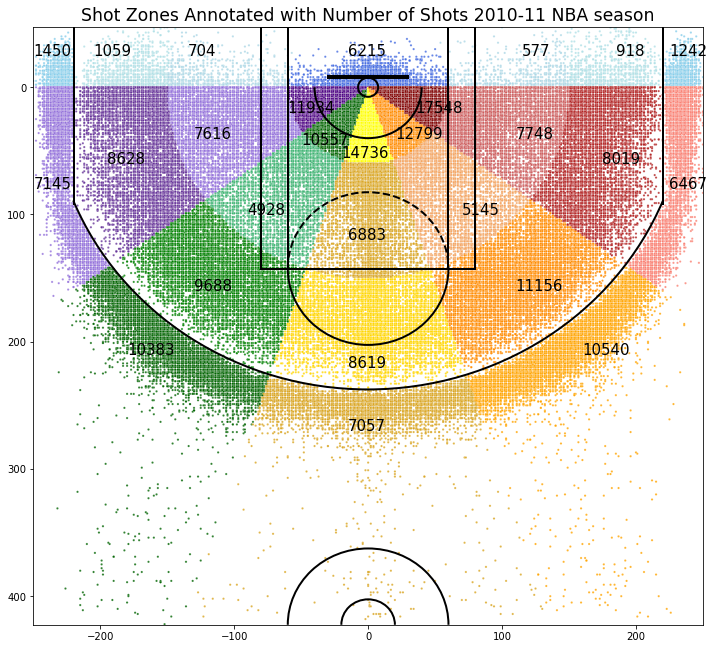

In [ ]:
# Create a shot chart that is colored by shot zone and annotated with the number of shots taken in each shot zone
# from the 2010-11 NBA season
plt.figure(figsize=(12,11))
sns.scatterplot(x = 'LOC_X', y = 'LOC_Y', data = shots_df_10, alpha = 0.8, hue = shots_df_10.shot_zone, palette = palette_num_shots_10, s = 5)
# Draw the court in the background with draw_court()
draw_court()

# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along the y axis from bottom to top in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
plt.xlabel('')
plt.ylabel('')
plt.tick_params(labelbottom='off', labelleft='off')

# Use plt.annotate and the values from num_shots_by_zone_10 to annotate the number of shots taken by shot zone 
# for 2010-11 onto the plot
plt.annotate(num_shots_by_zone_10[0], (-15, -25), fontsize = 15)
plt.annotate(num_shots_by_zone_10[1], (35, 20), fontsize = 15)
plt.annotate(num_shots_by_zone_10[2], (20, 40), fontsize = 15)
plt.annotate(num_shots_by_zone_10[3], (-20, 55), fontsize = 15)
plt.annotate(num_shots_by_zone_10[4], (-50, 45), fontsize = 15)
plt.annotate(num_shots_by_zone_10[5], (-60, 20), fontsize = 15)
plt.annotate(num_shots_by_zone_10[6], (115, -25), fontsize = 15)
plt.annotate(num_shots_by_zone_10[7], (110, 40), fontsize = 15)
plt.annotate(num_shots_by_zone_10[8], (70, 100), fontsize = 15)
plt.annotate(num_shots_by_zone_10[9], (-15, 120), fontsize = 15)
plt.annotate(num_shots_by_zone_10[10], (-90, 100), fontsize = 15)
plt.annotate(num_shots_by_zone_10[11], (-130, 40), fontsize = 15)
plt.annotate(num_shots_by_zone_10[12], (-135, -25), fontsize = 15)
plt.annotate(num_shots_by_zone_10[13], (185, -25), fontsize = 15)
plt.annotate(num_shots_by_zone_10[14], (175, 60), fontsize = 15)
plt.annotate(num_shots_by_zone_10[15], (110, 160), fontsize = 15)
plt.annotate(num_shots_by_zone_10[16], (-15, 220), fontsize = 15)
plt.annotate(num_shots_by_zone_10[17], (-130, 160), fontsize = 15)
plt.annotate(num_shots_by_zone_10[18], (-195, 60), fontsize = 15)
plt.annotate(num_shots_by_zone_10[19], (-205, -25), fontsize = 15)
plt.annotate(num_shots_by_zone_10[20], (225, -25), fontsize = 15)
plt.annotate(num_shots_by_zone_10[21], (225, 80), fontsize = 15)
plt.annotate(num_shots_by_zone_10[22], (160, 210), fontsize = 15)
plt.annotate(num_shots_by_zone_10[23], (-15, 270), fontsize = 15)
plt.annotate(num_shots_by_zone_10[24], (-180, 210), fontsize = 15)
plt.annotate(num_shots_by_zone_10[25], (-250, 80), fontsize = 15)
plt.annotate(num_shots_by_zone_10[26], (-250, -25), fontsize = 15)

# Remove the legend from the plot
plt.legend([],[], frameon=False)
# Add a title to the plot
plt.title('Shot Zones Annotated with Number of Shots 2010-11 NBA season', size='xx-large')

plt.show()

In [ ]:
# Create a color palette that colors each sector of shot zones the same color
palette_num_shots = sns.color_palette(['royalblue', 'darkred', 'orange', 'yellow', 'green', 'rebeccapurple', 'powderblue', 'lightcoral', 'sandybrown', 'gold', 'mediumseagreen', 'plum', 'powderblue', 'powderblue', 'lightsalmon', 'navajowhite', 'khaki', 'lightgreen', 'thistle', 'powderblue', 'skyblue', 'firebrick', 'darkorange', 'yellow', 'darkgreen', 'rebeccapurple', 'skyblue'], n_colors=27)

When comparing the 2020-21 and 2010-11 seasons, we noticed that far less shots are attempted from the deep mid-range zones in 2020-21.​ These deep mid-range shots seem to have been traded for shots beyond the 3-point line.​ We can also see that there are clear concentrations beyond the 3-point line and around the basket.

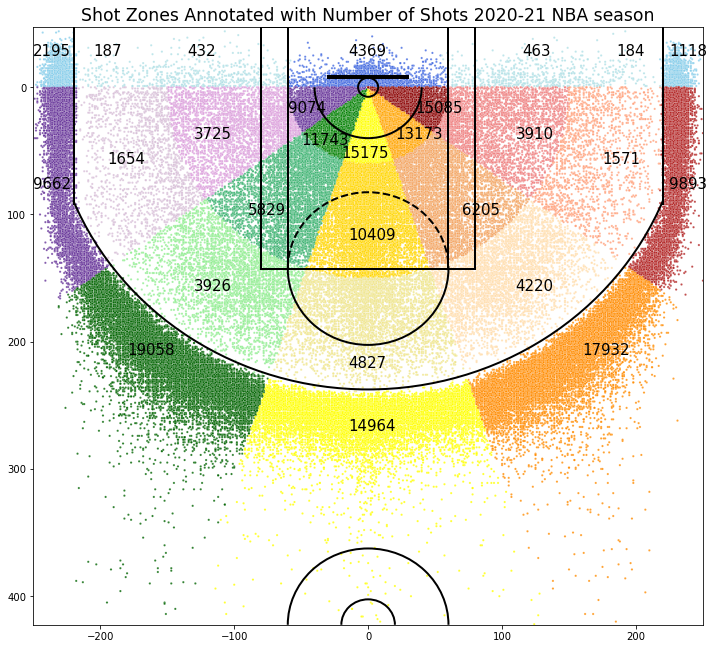

In [ ]:
# Create a shot chart that is colored by shot zone and annotated with the number of shots taken in each shot zone
# from the 2020-21 NBA season
plt.figure(figsize=(12,11))
sns.scatterplot(x = 'LOC_X', y = 'LOC_Y', data = shots_df, alpha = 0.8, hue = shots_df.shot_zone, palette = palette_num_shots, s = 5)
# Draw the court in the background with draw_court()
draw_court()

# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along the y axis from bottom to top in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
plt.xlabel('')
plt.ylabel('')
plt.tick_params(labelbottom='off', labelleft='off')

# Use plt.annotate and the values from num_shots_by_zone_10 to annotate the number of shots taken by shot zone 
# for 2010-11 onto the plot
plt.annotate(num_shots_by_zone[0], (-15, -25), fontsize = 15)
plt.annotate(num_shots_by_zone[1], (35, 20), fontsize = 15)
plt.annotate(num_shots_by_zone[2], (20, 40), fontsize = 15)
plt.annotate(num_shots_by_zone[3], (-20, 55), fontsize = 15)
plt.annotate(num_shots_by_zone[4], (-50, 45), fontsize = 15)
plt.annotate(num_shots_by_zone[5], (-60, 20), fontsize = 15)
plt.annotate(num_shots_by_zone[6], (115, -25), fontsize = 15)
plt.annotate(num_shots_by_zone[7], (110, 40), fontsize = 15)
plt.annotate(num_shots_by_zone[8], (70, 100), fontsize = 15)
plt.annotate(num_shots_by_zone[9], (-15, 120), fontsize = 15)
plt.annotate(num_shots_by_zone[10], (-90, 100), fontsize = 15)
plt.annotate(num_shots_by_zone[11], (-130, 40), fontsize = 15)
plt.annotate(num_shots_by_zone[12], (-135, -25), fontsize = 15)
plt.annotate(num_shots_by_zone[13], (185, -25), fontsize = 15)
plt.annotate(num_shots_by_zone[14], (175, 60), fontsize = 15)
plt.annotate(num_shots_by_zone[15], (110, 160), fontsize = 15)
plt.annotate(num_shots_by_zone[16], (-15, 220), fontsize = 15)
plt.annotate(num_shots_by_zone[17], (-130, 160), fontsize = 15)
plt.annotate(num_shots_by_zone[18], (-195, 60), fontsize = 15)
plt.annotate(num_shots_by_zone[19], (-205, -25), fontsize = 15)
plt.annotate(num_shots_by_zone[20], (225, -25), fontsize = 15)
plt.annotate(num_shots_by_zone[21], (225, 80), fontsize = 15)
plt.annotate(num_shots_by_zone[22], (160, 210), fontsize = 15)
plt.annotate(num_shots_by_zone[23], (-15, 270), fontsize = 15)
plt.annotate(num_shots_by_zone[24], (-180, 210), fontsize = 15)
plt.annotate(num_shots_by_zone[25], (-250, 80), fontsize = 15)
plt.annotate(num_shots_by_zone[26], (-250, -25), fontsize = 15)

# Remove the legend from the plot
plt.legend([],[], frameon=False)
# Add a title to the plot
plt.title('Shot Zones Annotated with Number of Shots 2020-21 NBA season', size='xx-large')

plt.show()

In [25]:
# Group shots_df and shots_df_10 by 'shot_zone' and find the mean points per shot for each shot zone
pps_by_shot_zone = shots_df.groupby('shot_zone').agg({'points_per_shot' : np.mean})
pps_by_shot_zone_10 = shots_df_10.groupby('shot_zone').agg({'points_per_shot' : np.mean})

# Convert the mean points per shot values into a list format
pps_by_shot_zone_list = pps_by_shot_zone['points_per_shot'].round(2).to_list()
pps_by_shot_zone_10_list = pps_by_shot_zone_10['points_per_shot'].round(2).to_list()

In [ ]:
# Create a color palette to get 27 distinct colors for each of the 27 shot zones
palette_pps_10 = sns.color_palette(['midnightblue', 'darkred', 'darkorange', 'yellow', 'darkgreen', 'rebeccapurple', 'skyblue', 'salmon', 'peachpuff', 'khaki', 'palegreen', 'thistle', 'skyblue', 'royalblue', 'tomato', 'sandybrown', 'palegoldenrod', 'lightgreen', 'plum', 'royalblue', 'mediumblue', 'firebrick', 'darkorange', 'gold', 'green', 'rebeccapurple', 'mediumblue'], n_colors=27)

Next, we wanted to see the efficiency from each shot zone, so we made a shot chart colored by the average points per shot for each shot zone and annotated with the average points per shot in each shot zone. We found that despite the large number of attempts from mid-range, the only zones with above 0.9 PPS are beyond the 3-point line or within 6ft of the basket. When considering that the average points per shot for all shots in 2010-11 was 1.00, this means that all shots taken in the mid-range zones resulted in below average efficiency.

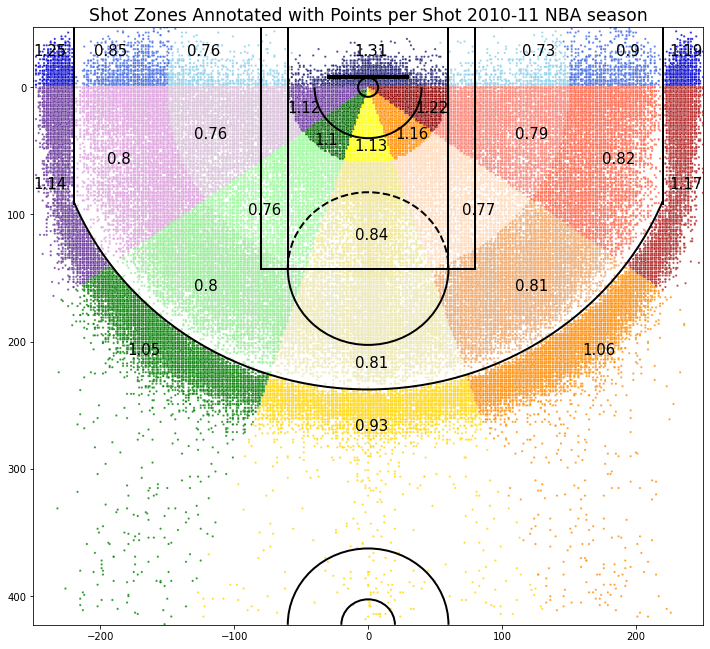

In [85]:
# Create a shot chart that is colored by shot zone and annotated with the average points per shot in each shot zone
# from the 2010-11 NBA season
plt.figure(figsize=(12,11))
sns.scatterplot(x = 'LOC_X', y = 'LOC_Y', data = shots_df_10, alpha = 0.8, hue = shots_df_10.shot_zone, palette = palette_pps_10, s = 5)
# Draw the court in the background with draw_court()
draw_court()

# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along the y axis from bottom to top in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
plt.xlabel('')
plt.ylabel('')
plt.tick_params(labelbottom='off', labelleft='off')

# Use plt.annotate and the values from the pps_by_shot_zone_10_list to annotate the mean points per shot by shot zone 
# for 2010-11 onto the plot
plt.annotate(pps_by_shot_zone_10_list[0], (-10, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[1], (35, 20), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[2], (20, 40), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[3], (-10, 50), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[4], (-40, 45), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[5], (-60, 20), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[6], (115, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[7], (110, 40), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[8], (70, 100), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[9], (-10, 120), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[10], (-90, 100), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[11], (-130, 40), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[12], (-135, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[13], (185, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[14], (175, 60), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[15], (110, 160), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[16], (-10, 220), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[17], (-130, 160), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[18], (-195, 60), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[19], (-205, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[20], (225, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[21], (225, 80), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[22], (160, 210), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[23], (-10, 270), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[24], (-180, 210), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[25], (-250, 80), fontsize = 15)
plt.annotate(pps_by_shot_zone_10_list[26], (-250, -25), fontsize = 15)

# Remove the legend from the plot
plt.legend([],[], frameon=False)
# Add a title to the plot
plt.title('Shot Zones Annotated with Points per Shot 2010-11 NBA season', size='xx-large')

plt.show()

In [ ]:
# Create a color palette that colors each sector of shot zones the same color
palette_pps = sns.color_palette(['midnightblue', 'darkred', 'darkorange', 'yellow', 'darkgreen', 'rebeccapurple', 'royalblue', 'tomato', 'orange', 'gold', 'mediumseagreen', 'mediumpurple', 'royalblue', 'skyblue', 'tomato', 'sandybrown', 'khaki', 'lightgreen', 'plum', 'skyblue', 'mediumblue', 'firebrick', 'darkorange', 'goldenrod', 'green', 'rebeccapurple', 'mediumblue'], n_colors=27)

When comparing the 2020-21 and 2010-11 seasons, we noticed a very similar trend. In 2020-21 we found that the 3-point zones have around a 0.2-0.4 PPS advantage over the deep mid-range zones. We also again found that all of the shots taken from mid-range zones yielded far below average efficiency.

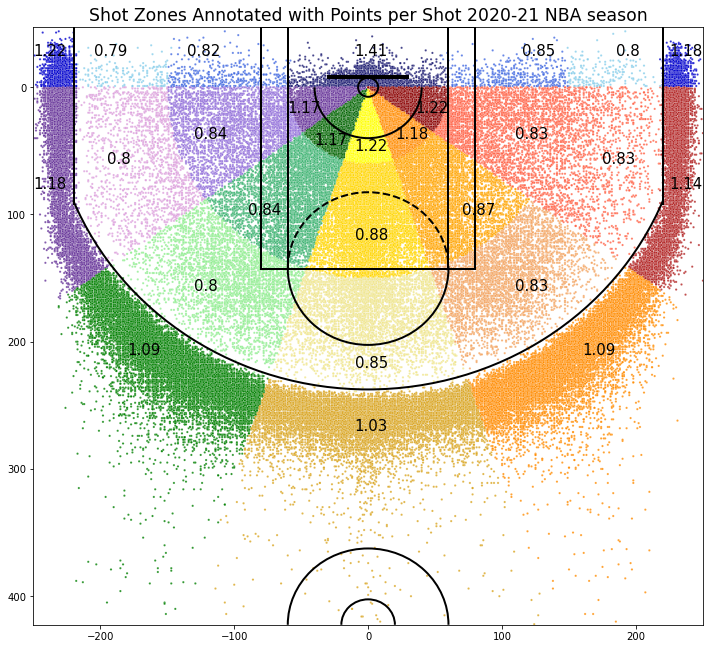

In [ ]:
# Create a shot chart that is colored by shot zone and annotated with the average points per shot in each shot zone
# from the 2020-21 NBA season
plt.figure(figsize=(12,11))
sns.scatterplot(x = 'LOC_X', y = 'LOC_Y', data = shots_df, alpha = 0.8, hue = shots_df.shot_zone, palette = palette_pps, s = 5)
# Draw the court in the background with draw_court()
draw_court()

# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along the y axis from bottom to top in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
plt.xlabel('')
plt.ylabel('')
plt.tick_params(labelbottom='off', labelleft='off')

# Use plt.annotate and the values from the pps_by_shot_zone_list to annotate the mean points per shot by shot zone 
# for 2020-21 onto the plot
plt.annotate(pps_by_shot_zone_list[0], (-10, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[1], (35, 20), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[2], (20, 40), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[3], (-10, 50), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[4], (-40, 45), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[5], (-60, 20), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[6], (115, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[7], (110, 40), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[8], (70, 100), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[9], (-10, 120), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[10], (-90, 100), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[11], (-130, 40), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[12], (-135, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[13], (185, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[14], (175, 60), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[15], (110, 160), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[16], (-10, 220), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[17], (-130, 160), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[18], (-195, 60), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[19], (-205, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[20], (225, -25), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[21], (225, 80), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[22], (160, 210), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[23], (-10, 270), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[24], (-180, 210), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[25], (-250, 80), fontsize = 15)
plt.annotate(pps_by_shot_zone_list[26], (-250, -25), fontsize = 15)

# Remove the legend from the plot
plt.legend([],[], frameon=False)
# Add a title to the plot
plt.title('Shot Zones Annotated with Points per Shot 2020-21 NBA season', size='xx-large')

plt.show()

In [ ]:
# Shot Zone statistic generation chunk
# Filter shot_zone, and then grouped it by shot_zone and summed up the variables
shot_zone_df = shots_df[['shot_zone','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG','points_per_shot']]
shot_zone_df_final = shot_zone_df.groupby(['shot_zone']).sum().reset_index()

# Calculate points per shot zone and shot percentage
shot_zone_df_final['shot_zone_pps'] = shot_zone_df_final['points_per_shot'] / shot_zone_df_final['SHOT_ATTEMPTED_FLAG']
shot_zone_df_final['shot_zone_percentage'] =  shot_zone_df_final['SHOT_MADE_FLAG'] / shot_zone_df_final['SHOT_ATTEMPTED_FLAG']


# Filter shot_zone, and then grouped it by shot_zone and summed up the variables
shot_zone_df_10 = shots_df_10[['shot_zone','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG','points_per_shot']]
shot_zone_df_10_final = shot_zone_df_10.groupby(['shot_zone']).sum().reset_index()

# Calculate points per shot zone and shot percentage
shot_zone_df_10_final['shot_zone_pps'] = shot_zone_df_10_final['points_per_shot'] / shot_zone_df_10_final['SHOT_ATTEMPTED_FLAG']
shot_zone_df_10_final['shot_zone_percentage'] =  shot_zone_df_10_final['SHOT_MADE_FLAG'] / shot_zone_df_10_final['SHOT_ATTEMPTED_FLAG']

In [ ]:
# Graph Creation Chunk

# Create graph object
fig, ax = plt.subplots(1,2, figsize = (15,6))

# Plot first graph
shot_zone_df_10_final.plot(x="shot_zone", y=["shot_zone_pps", "shot_zone_percentage"], kind="bar", ax=ax[0])
# Create axis labels
ax[0].title.set_text("Shot Zone Stats - 2010-11 NBA Season")
ax[0].set_xlabel("Shot Zones")
ax[0].tick_params(axis='x', labelrotation = 0)

# Plot second graph
shot_zone_df_final.plot(x="shot_zone", y=["shot_zone_pps", "shot_zone_percentage"], kind="bar", ax=ax[1])
# Create axis labels
ax[1].title.set_text("Shot Zone Stats - 2020-21 NBA Season")
ax[1].set_xlabel("Shot Zones")
ax[1].tick_params(axis='x', labelrotation = 0)

# Show Plot
plt.show()

## Linear Regression Analysis


Next we ran some linear regression analysis to take a deeper look into the relationship between efficiency and the mass increase of three-point shots taken. The black line in the graph represents the average amount of points a player is expected to score based on how many shots they take. Each player is assigned a <b>"score"</b> which is equal to their residual, or how far above or below the average line they are. If a player has a positive score then they score more points per game than expected based off how many shots they take a game, and this means they are more efficient in their shot taking than the average player. If a player's score is negative then they score less than what is expected, and they are more inefficient than the average player.

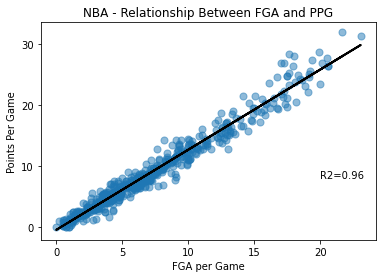

<Figure size 720x576 with 0 Axes>

In [2]:
# Here we access the leagueleaders module through endpoints & assign the class to "data"
data = leagueleaders.LeagueLeaders(
    season = '2020-21',
    season_type_all_star = 'Regular Season'
) 

# Our "data" variable now has built in functions such as creating a dataframe for our data
df21 = data.league_leaders.get_data_frame()

# Create a variable for points per game 
df21['PPG'] = df21['PTS'] / df21['GP']

# First we need to get per game stats.
# We divide each variable by games played (GP) to get per game average
x, y = df21.FGA/df21.GP, df21.PTS/df21.GP 

# we have to reshape our array from 1d to 2d. 
# The proper shaped array is an input requirement for the linear model
# reshaping is usually an issue when using 1 x variable
x = np.array(x).reshape(-1,1)     
y = np.array(y).reshape(-1,1)     

""" Build and fit linea regression model """
# create an object that contains the linear model class
# Fit our modeling using FGA (x) and PPG (y)
model = linear_model.LinearRegression()    
model.fit(x,y)                             

# Get our r2 value and round it to 2 decimals. How much variance is exaplained?
# Get our predicted y values for x
r2 = round(model.score(x,y), 2)            
predicted_y = model.predict(x)   

# Now, lets make a plot with matplot lib using a iterative approach (which is easy to read)

plt.scatter(x, y, s=50, alpha=.5)                            # Scatterplot:  Specfiy size(s) and transparency(alpha) of dots
plt.plot(x, predicted_y, color = 'black', linewidth=2)       # line: Add line for regression line w/ predicted values
plt.title('NBA - Relationship Between FGA and PPG')          # Give it a title
plt.xlabel('FGA per Game')                                   # Label x-axis
plt.ylabel('Points Per Game')                                # Label y-axis
plt.text(20,8, f'R2={r2}')                                   # 10, 25 are the coordinates for our text. Adjust accordingly
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 8))

plt.show()

In [4]:
import heapq

# create an array of values 'score'
# These values were (POINTS PER GAME - EXPECTED POINTS PER GAME)
# In other words, the players who were BEST outperforming our line of regression

score = (y - predicted_y)

# Using heapq to find the indexes of the 10 largest PPG - ExPPG in the NBA (most efficient players) and storing
# Them to player_index
player_index = heapq.nlargest(11, range(len(score)), score.take)

# A new list to store information from the original DataFrame
most_efficient21 = []

# Using our original DataFrame, appending all player information for my 10 most efficient players to my
# 'most_efficient' list
for i in range(len(player_index)):
    most_efficient21.append(df21.loc[player_index[i]])

# Creating a new DataFrame called 'most_efficient_DF' from my 'most_efficient' list
most_efficient21_DF = pd.DataFrame(most_efficient21)

# Creating a filter for at least 600 shot attempts
most_efficient21_DF = most_efficient21_DF[most_efficient21_DF['FGA'] > 600]

# Resetting player_index list so that it only contains those with at least 600 shot attempts
player_index21 = most_efficient21_DF.index

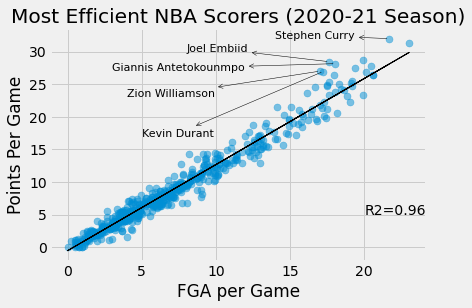

<Figure size 1728x1152 with 0 Axes>

In [5]:
# Now, lets make a plot with matplot lib using a iterative approach (which is easy to read)

plt.scatter(x, y, s=50, alpha=.5)                                 # Scatterplot:  Specfiy size(s) and transparency(alpha) of dots
plt.plot(x, predicted_y, color = 'black', linewidth=1)            # line: Add line for regression line w/ predicted values
plt.title('Most Efficient NBA Scorers (2020-21 Season)')          # Give it a title
plt.xlabel('FGA per Game')                                        # Label x-axis
plt.ylabel('Points Per Game')                                     # Label y-axis
plt.text(20,5, f'R2={r2}')                                        # 10, 25 are the coordinates for our text. Adjust accordingly


plt.annotate(most_efficient21_DF.PLAYER[player_index21[0]], 
                 (x[player_index21[0]], y[player_index21[0]]), 
                 (8, 30),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(most_efficient21_DF.PLAYER[player_index21[1]], 
                 (x[player_index21[1]], y[player_index21[1]]), 
                 (4, 23),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(most_efficient21_DF.PLAYER[player_index21[4]], 
                 (x[player_index21[4]], y[player_index21[4]]), 
                 (14, 32),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(most_efficient21_DF.PLAYER[player_index21[2]], 
                 (x[player_index21[2]], y[player_index21[2]]), 
                 (3, 27),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(most_efficient21_DF.PLAYER[player_index21[3]], 
                 (x[player_index21[3]], y[player_index21[3]]), 
                 (5, 17),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(24, 16))

plt.show()

As you can see here, one of the most efficient players in the NBA was <b>Stephen Curry</b>. This is significant because his playstyle, particularly the fact that he takes a lot of threes, was revolutionary to the game of basketball. And when you look at his score, his playstyle reflects very well on his efficiency.

In [6]:
# Using heapq to find the indexes of the 10 smallest PPG - ExPPG in the NBA (least efficient players) and storing
# Them to player_index
player_index21_2 = heapq.nsmallest(20, range(len(score)), score.take)

# A new list to store information from the original DataFrame
least_efficient21 = []

# Using our original DataFrame, appending all player information for my 10 least efficient players to my
# 'least_efficient' list
for i in range(len(player_index21_2)):
    least_efficient21.append(df21.loc[player_index21_2[i]])

# Creating a new DataFrame called 'least_efficient_DF' from my 'least_effecient' list
least_efficient21_df = pd.DataFrame(least_efficient21)

# Creating a filter for at least 500 shot attempts
least_efficient21_df = least_efficient21_df[least_efficient21_df['FGA'] > 500]

# Resetting player_index2 list so that it only contains those with at least 500 shot attempts
player_index21_2 = least_efficient21_df.index

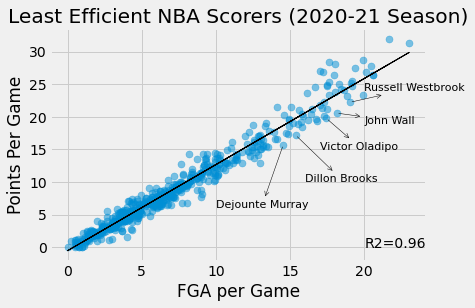

<Figure size 1728x1152 with 0 Axes>

In [7]:
x, y = df21.FGA/df21.GP, df21.PTS/df21.GP 

# we have to reshape our array from 1d to 2d. 
# The proper shaped array is an input requirement for the linear model
# reshaping is usually an issue when using 1 x variable
x = np.array(x).reshape(-1,1)     
y = np.array(y).reshape(-1,1)     


# create an object that contains the linear model class
# Fit our modeling using FGA (x) and PPG (y)
model = linear_model.LinearRegression()    
model.fit(x,y)                             

# Get our r2 value and round it to 2 decimals. How much variance is exaplained?
# Get our predicted y values for x
r2 = round(model.score(x,y), 2)            
predicted_y = model.predict(x)   

# Now, lets make a plot with matplot lib using a iterative approach (which is easy to read)

plt.scatter(x, y, s=50, alpha=.5)                                   # Scatterplot:  Specfiy size(s) and transparency(alpha) of dots
plt.plot(x, predicted_y, color = 'black', linewidth=1)              # line: Add line for regression line w/ predicted values
plt.title('Least Efficient NBA Scorers (2020-21 Season)')           # Give it a title
plt.xlabel('FGA per Game')                                          # Label x-axis
plt.ylabel('Points Per Game')                                       # Label y-axis
plt.text(20,0, f'R2={r2}')                                          # 10, 25 are the coordinates for our text. Adjust accordingly

# In order to point out my 10 least efficient players on the graph, I used plt.annotate and plugged in the
# indexes from 'player_index2' list with lines drawn to their dots
plt.annotate(least_efficient21_df.PLAYER[player_index21_2[0]], 
                 (x[player_index21_2[0]], y[player_index21_2[0]]), 
                 (10, 6),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(least_efficient21_df.PLAYER[player_index21_2[1]], 
                 (x[player_index21_2[1]], y[player_index21_2[1]]), 
                 (20, 19),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(least_efficient21_df.PLAYER[player_index21_2[2]], 
                 (x[player_index21_2[2]], y[player_index21_2[2]]), 
                 (17, 15),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(least_efficient21_df.PLAYER[player_index21_2[3]], 
                 (x[player_index21_2[3]], y[player_index21_2[3]]), 
                 (16, 10),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(least_efficient21_df.PLAYER[player_index21_2[4]], 
                 (x[player_index21_2[4]], y[player_index21_2[4]]), 
                 (20, 24),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(24, 16))
plt.show()

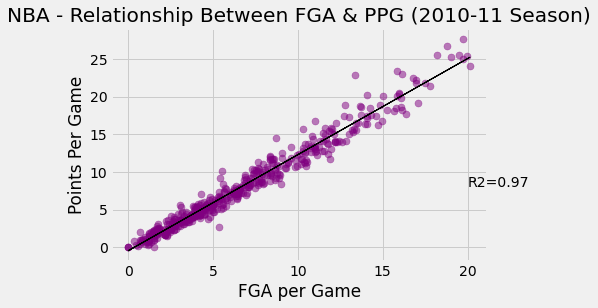

<Figure size 1728x1152 with 0 Axes>

In [8]:
# Do it all again for the 2010-11 season

# Here we access the leagueleaders module through endpoints & assign the class to "data"
data = leagueleaders.LeagueLeaders(
    season = '2010-11',
    season_type_all_star = 'Regular Season'
) 

# Our "data" variable now has built in functions such as creating a dataframe for our data
df = data.league_leaders.get_data_frame()

# Create a variable for points per game 
df['PPG'] = df['PTS'] / df['GP']

# # First we need to get per game stats.
# # We divide each variable by games played (GP) to get per game average
x, y = df.FGA/df.GP, df.PTS/df.GP 

# # we have to reshape our array from 1d to 2d. 
# # The proper shaped array is an input requirement for the linear model
# # reshaping is usually an issue when using 1 x variable
x = np.array(x).reshape(-1,1)     
y = np.array(y).reshape(-1,1)     

# """ Build and fit linea regression model """
# # create an object that contains the linear model class
# # Fit our modeling using FGA (x) and PPG (y)
model = linear_model.LinearRegression()    
model.fit(x,y)                             

# # Get our r2 value and round it to 2 decimals. How much variance is exaplained?
# # Get our predicted y values for x
r2 = round(model.score(x,y), 2)            
predicted_y = model.predict(x)   

# # Now, lets make a plot with matplot lib using a iterative approach (which is easy to read)

plt.scatter(x, y, s=50, alpha=.5, color='purple')                           # Scatterplot:  Specfiy size(s) and transparency(alpha) of dots
plt.plot(x, predicted_y, color = 'black', linewidth=1)                      # line: Add line for regression line w/ predicted values
plt.title('NBA - Relationship Between FGA & PPG (2010-11 Season)')          # Give it a title
plt.xlabel('FGA per Game')                                                  # Label x-axis
plt.ylabel('Points Per Game')                                               # Label y-axis
plt.text(20,8, f'R2={r2}')                                                  # 10, 25 are the coordinates for our text. Adjust accordingly
plt.style.use('fivethirtyeight')
plt.figure(figsize=(24, 16))
plt.show()

In [9]:
# create an array of values 'score'
# These values were (POINTS PER GAME - EXPECTED POINTS PER GAME)
# In other words, the players who were BEST outperforming our line of regression

score = (y - predicted_y)

# Using heapq to find the indexes of the 10 largest PPG - ExPPG in the NBA (most efficient players) and storing
# Them to player_index
player_index = heapq.nlargest(11, range(len(score)), score.take)

# A new list to store information from the original DataFrame
most_efficient = []

# Using our original DataFrame, appending all player information for my 10 most efficient players to my
# 'most_efficient' list
for i in range(len(player_index)):
    most_efficient.append(df.loc[player_index[i]])

# Creating a new DataFrame called 'most_efficient_DF' from my 'most_efficient' list
most_efficient_df = pd.DataFrame(most_efficient)

# Creating a filter for at least 500 shot attempts
most_efficient_df = most_efficient_df[most_efficient_df['FGA'] > 500]

# Resetting player_index list so that it only contains those with at least 500 shot attempts
player_index = most_efficient_df.index

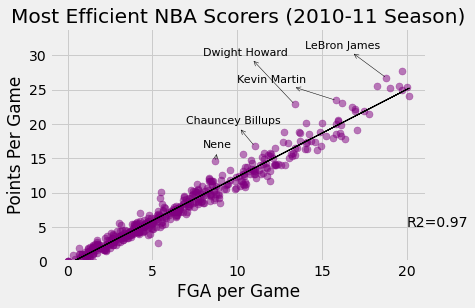

<Figure size 1728x1152 with 0 Axes>

In [13]:
plt.scatter(x, y, s=50, alpha=.5, color='purple')            # Scatterplot:  Specfiy size(s) and transparency(alpha) of dots
plt.plot(x, predicted_y, color = 'black', linewidth=1)       # line: Add line for regression line w/ predicted values
plt.title('Most Efficient NBA Scorers (2010-11 Season)')     # Give it a title
plt.xlabel('FGA per Game')                                   # Label x-axis
plt.ylabel('Points Per Game')                                # Label y-axis
plt.text(20,5, f'R2={r2}')                                   # 10, 25 are the coordinates for our text. Adjust accordingly

plt.annotate(most_efficient_df.PLAYER[player_index[0]], 
                 (x[player_index[0]], y[player_index[0]]), 
                 (8, 30),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(most_efficient_df.PLAYER[player_index[1]], 
                 (x[player_index[1]], y[player_index[1]]), 
                 (8, 16.5),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(most_efficient_df.PLAYER[player_index[4]], 
                 (x[player_index[4]], y[player_index[4]]), 
                 (7, 20),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(most_efficient_df.PLAYER[player_index[2]], 
                 (x[player_index[2]], y[player_index[2]]), 
                 (10, 26),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(most_efficient_df.PLAYER[player_index[3]], 
                 (x[player_index[3]], y[player_index[3]]), 
                 (14, 31),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.style.use('fivethirtyeight')
plt.ylim([0, 34])
plt.figure(figsize=(24, 16))
print(' ')

In the 2010-11 NBA season the most efficient players were primarily big men. This is because three-point shots were not being taken as often as they are now, so big men were the most efficient by default. They were the most efficient because they were taking the closest shots to the basket due to the fact that they are more physically dominant than the other "smaller" positions. 

In [14]:
# Using heapq to find the indexes of the 10 smallest PPG - ExPPG in the NBA (least efficient players) and storing
# Them to player_index
player_index2 = heapq.nsmallest(20, range(len(score)), score.take)

# A new list to store information from the original DataFrame
least_efficient = []

# Using our original DataFrame, appending all player information for my 10 least efficient players to my
# 'least_efficient' list
for i in range(len(player_index2)):
    least_efficient.append(df.loc[player_index2[i]])

# Creating a new DataFrame called 'least_efficient_DF' from my 'least_effecient' list
least_efficient_df = pd.DataFrame(least_efficient)

# Creating a filter for at least 500 shot attempts
least_efficient_df = least_efficient_df[least_efficient_df['FGA'] > 700]

# Resetting player_index2 list so that it only contains those with at least 500 shot attempts
player_index2 = least_efficient_df.index

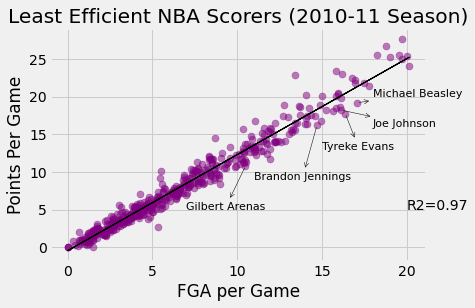

<Figure size 1728x1152 with 0 Axes>

In [15]:
x, y = df.FGA/df.GP, df.PTS/df.GP 

# we have to reshape our array from 1d to 2d. 
# The proper shaped array is an input requirement for the linear model
# reshaping is usually an issue when using 1 x variable
x = np.array(x).reshape(-1,1)     
y = np.array(y).reshape(-1,1)     


# create an object that contains the linear model class
# Fit our modeling using FGA (x) and PPG (y)
model = linear_model.LinearRegression()    
model.fit(x,y)                             

# Get our r2 value and round it to 2 decimals. How much variance is exaplained?
# Get our predicted y values for x
r2 = round(model.score(x,y), 2)            
predicted_y = model.predict(x)   

# Now, lets make a plot with matplot lib using a iterative approach (which is easy to read)

plt.scatter(x, y, s=50, alpha=.5, color='purple')                   # Scatterplot:  Specfiy size(s) and transparency(alpha) of dots
plt.plot(x, predicted_y, color = 'black', linewidth=1)              # line: Add line for regression line w/ predicted values
plt.title('Least Efficient NBA Scorers (2010-11 Season)')           # Give it a title
plt.xlabel('FGA per Game')                                          # Label x-axis
plt.ylabel('Points Per Game')                                       # Label y-axis
plt.text(20,5, f'R2={r2}')                                          # 10, 25 are the coordinates for our text. Adjust accordingly

plt.annotate(least_efficient_df.PLAYER[player_index2[0]], 
                 (x[player_index2[0]], y[player_index2[0]]), 
                 (15, 13),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(least_efficient_df.PLAYER[player_index2[1]], 
                 (x[player_index2[1]], y[player_index2[1]]), 
                 (7, 5),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(least_efficient_df.PLAYER[player_index2[4]], 
                 (x[player_index2[4]], y[player_index2[4]]), 
                 (18, 16),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(least_efficient_df.PLAYER[player_index2[2]], 
                 (x[player_index2[2]], y[player_index2[2]]), 
                 (18, 20),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.annotate(least_efficient_df.PLAYER[player_index2[3]], 
                 (x[player_index2[3]], y[player_index2[3]]), 
                 (11, 9),
                 arrowprops=dict(arrowstyle='<-', color = 'black'),
                 fontsize=11)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(24, 16))
plt.show()

For people who are dedicated NBA fans the common denomiator between the most inefficient players is obvious. However, for those who don't find the parallels to be as intuitive the shot charts below provide a visual representation of what has been true for these players then and now.

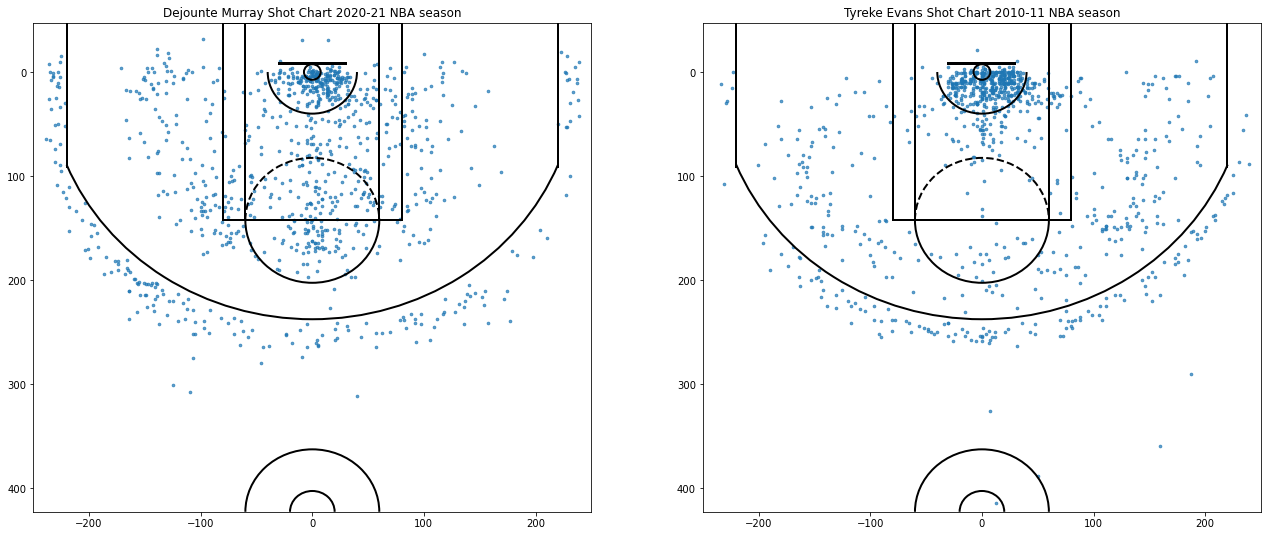

In [8]:
fig, ax = plt.subplots(1,2, figsize = (22,9))

ax[0].scatter(x = 'LOC_X', y = 'LOC_Y', data = shots_df[shots_df['PLAYER_NAME'] == 'Dejounte Murray'], alpha = 0.7, s = 7)
draw_court(ax[0])
ax[0].set_xlim(-250,250)
ax[0].set_ylim(422.5, -47.5)
ax[0].title.set_text('Dejounte Murray Shot Chart 2020-21 NBA season')

ax[1].scatter(x = 'LOC_X', y = 'LOC_Y', data = shots_df_10[shots_df_10['PLAYER_NAME'] == 'Tyreke Evans'], alpha = 0.7, s = 7)
draw_court(ax[1])
ax[1].set_xlim(-250,250)
ax[1].set_ylim(422.5, -47.5)
ax[1].title.set_text('Tyreke Evans Shot Chart 2010-11 NBA season')

plt.show()

The common denominator mentioned above can be clearly seen in this chart, and that is <b>a lot of attempted mid range shots</b>. <b>Dejounte Murray</b> and <b>Tyreke Evans</b> were the most inefficient players in their repsective seasons, and both of them took a lot of mid range shots and not a whole lot of threes. 

In [ ]:
print('The average points per shot for Dejounte Murray is', shots_df.loc[shots_df['PLAYER_NAME'] == 'Dejounte Murray', 'points_per_shot'].mean().round(2))
print('The average points per shot for Tyreke Evans is', shots_df_10.loc[shots_df_10['PLAYER_NAME'] == 'Tyreke Evans', 'points_per_shot'].mean().round(2))

The average points per shot for Dejounte Murray is 0.97
The average points per shot for Tyreke Evans is 0.87


The average points per shot in 2020-21 was <b>1.08</b>, and in 2010-11 it was <b>1.00</b>. That means Murray's points per shot was <b>0.11</b> below the league average, and Evans was <b>0.13</b> below the league average in his respective season. The teams in the NBA want to maximize the amount of points that they can get in any given game so it is no surprise that players that fit the same mold as Evans and Murray are diminishing in value.

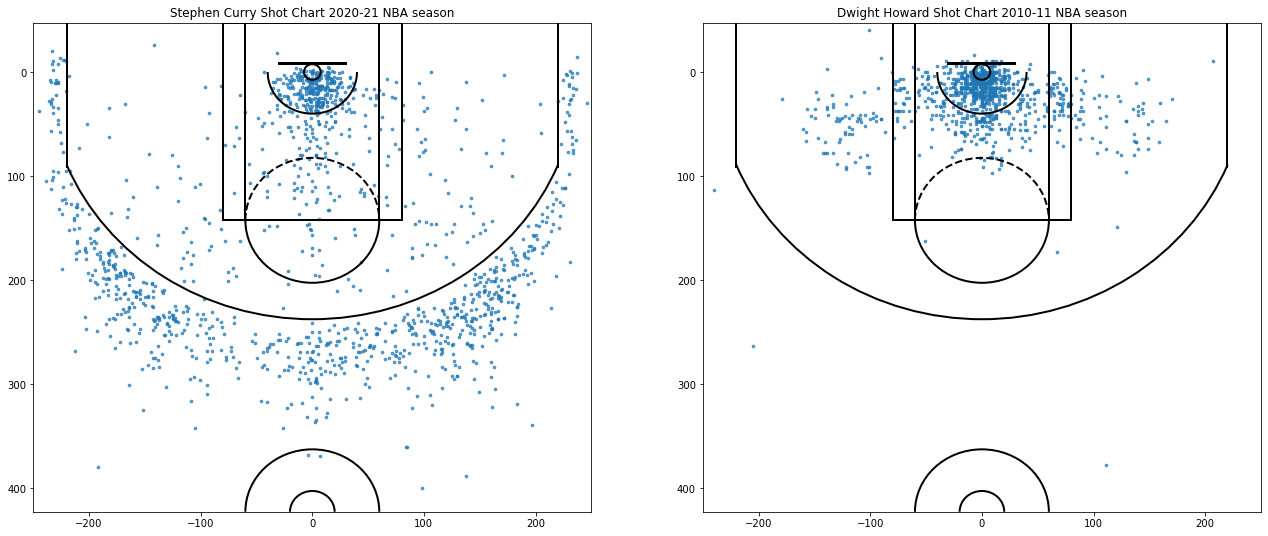

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (22,9))

ax[0].scatter(x = 'LOC_X', y = 'LOC_Y', data = shots_df[shots_df['PLAYER_NAME'] == 'Stephen Curry'], alpha = 0.7, s = 7)
draw_court(ax[0])
ax[0].set_xlim(-250,250)
ax[0].set_ylim(422.5, -47.5)
ax[0].title.set_text('Stephen Curry Shot Chart 2020-21 NBA season')

ax[1].scatter(x = 'LOC_X', y = 'LOC_Y', data = shots_df_10[shots_df_10['PLAYER_NAME'] == 'Dwight Howard'], alpha = 0.7, s = 7)
draw_court(ax[1])
ax[1].set_xlim(-250,250)
ax[1].set_ylim(422.5, -47.5)
ax[1].title.set_text('Dwight Howard Shot Chart 2010-11 NBA season')

plt.show()

This is the exact opposite of the previous shot chart. Curry shot almost exclusively from behind the three-point line or around the basket, and Howard set up shop in the paint. Both of these areas these players tended to shoot from are more efficient locations to shoot from, so basic economics tells you that these players do a better job of maximizing their scoring chances and as a byproduct they bring much more value to their teams than players like Evans and Murray.

In [ ]:
print('The average points per shot for Stephen Curry is', shots_df.loc[shots_df['PLAYER_NAME'] == 'Stephen Curry', 'points_per_shot'].mean().round(2))
print('The average points per shot for Dwight Howard is', shots_df_10.loc[shots_df_10['PLAYER_NAME'] == 'Dwight Howard', 'points_per_shot'].mean().round(2))

The average points per shot for Stephen Curry is 1.21
The average points per shot for Dwight Howard is 1.19


## Shot Chart Analysis of 30ft plus shots

C:\Users\Beger\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


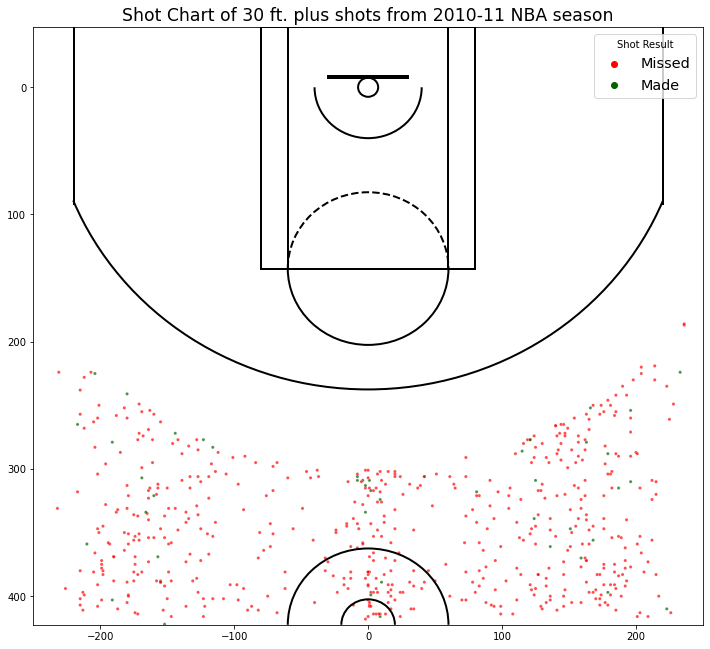

In [47]:

fig, ax = plt.subplots(figsize=(12,11))

scatter = sns.scatterplot(shots_df_10_30ft.LOC_X, shots_df_10_30ft.LOC_Y, alpha = 0.7, hue = shots_df_10_30ft.SHOT_MADE_FLAG, palette=palette, s = 10)

handles, labels  =  ax.get_legend_handles_labels()

ax.legend(handles, ['Missed', 'Made'], loc='upper right', fontsize = 'x-large', title = 'Shot Result')

draw_court(ax)
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

plt.title('Shot Chart of 30 ft. plus shots from 2010-11 NBA season', size='xx-large')

plt.show()

In 2010-11, seldom any shots were attempted from more than 30ft away from the basket, and most of those shots missed. If people were taking this shot it was usually out of desperation (think the time is running out and they are just heaving up a prayer). 1049 shots were taken, and they were made only <b>5.53%</b> of the time, good for <b>0.17 PPS</b>. Those numbers are terrible which further explains why it was hardly ever taken.


C:\Users\Beger\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


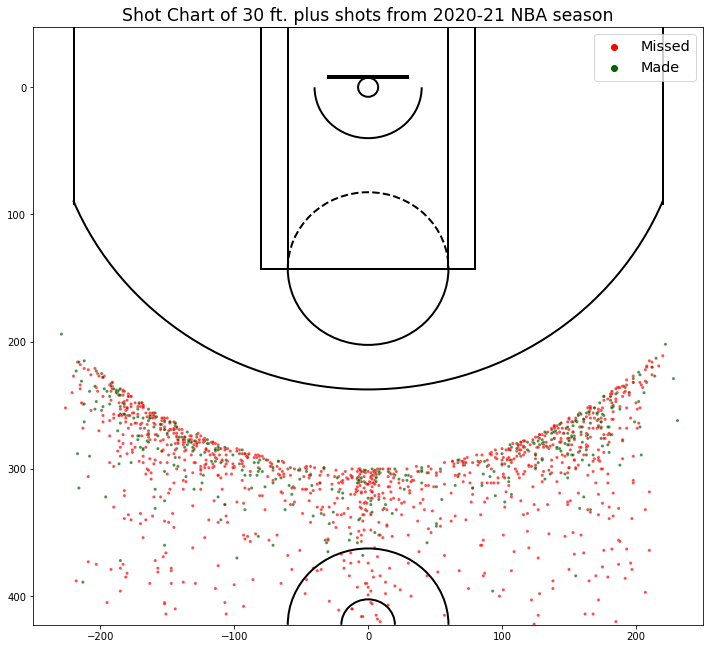

In [46]:

palette = sns.color_palette(['red', 'darkgreen'], 2)

fig, ax = plt.subplots(figsize=(12,11))

scatter = sns.scatterplot(shots_df_30ft.LOC_X, shots_df_30ft.LOC_Y, alpha = 0.7, hue = shots_df_30ft.SHOT_MADE_FLAG, palette=palette, s = 10)

handles, labels  =  ax.get_legend_handles_labels()

ax.legend(handles, ['Missed', 'Made'], loc='upper right', fontsize = 'x-large')

draw_court(ax)
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

plt.title('Shot Chart of 30 ft. plus shots from 2020-21 NBA season', size='xx-large')

plt.show()

By 2020-11, the number of shots taken more than 30ft away from the basket has increased tremendously. Players like Stephen Curry, who has a seemingly unlimited distance of space from the basket where he can make it from, are making it so that is more common to see deep three point shots like this. And the craziest part is that they are now taking these shots <b>on purpose</b>! 1743 shots were taken, and they were made only <b>23.58%</b> of the time, good for a respectable <b>0.71 PPS</b>. Super deep 3-pointers will probably never be a very efficient shot, but when you consider the fact that all mid-range shots were between 0.8 and 0.9 points per shot these 30+ foot shots are not that much less efficient despite being 10-20 feet farther from the basket (combined with the fact that these 30+ foot shots still include thos desperation shots we talked about earlier).


In [ ]:
shots_df_30ft = shots_df[shots_df['SHOT_DISTANCE'] >= 30]
print(np.mean(shots_df_30ft['points_per_shot']).round(2))
print(len(shots_df_30ft))
shots_made_30 = shots_df_30ft.groupby('SHOT_MADE_FLAG').size()
print(shots_made_30)
print((shots_made_30[1]/len(shots_df_30ft)) * 100)

0.71
1743
SHOT_MADE_FLAG
0    1332
1     411
dtype: int64
23.580034423407916


In [ ]:
shots_df_10_30ft = shots_df_10[shots_df_10['SHOT_DISTANCE'] >= 30]
print(np.mean(shots_df_10_30ft['points_per_shot']).round(2))
print(len(shots_df_10_30ft))
shots_made_10_30 = shots_df_10_30ft.groupby('SHOT_MADE_FLAG').size()
print(shots_made_10_30)
print((shots_made_10_30[1]/len(shots_df_10_30ft)) * 100)

0.17
1049
SHOT_MADE_FLAG
0    991
1     58
dtype: int64
5.529075309818875


## Hypothesis Testing
We wanted to test if there was a statistically significant difference in the proportion of total shot taken that are 3-pointers between the 2020-21 and 2010-11 NBA seasons. We used a 2 sample z-test for proportions and set our alpha equal to 0.05.

Null Hypothesis: The proportion of total shots that are 3-pointers is equal in 2020-21 and 2010-11. (H0: P1= P2)​

Alternative Hypothesis: The proportion of total shots that are 3-pointers in 2020-21 is greater than 2010-11. (H0: P1 > P2)

First, we created some contingency tables. One with the total shots that were 2-pointers and 3-pointers for 2020-21 and 2010-11, and one with the proportions of total shots.

In [16]:
df = shots_df.append(shots_df_10)
contingency_table = pd.crosstab(df.SHOT_TYPE,df.year)
contingency_table[1, 1]

NameError: name 'shots_df' is not defined

In [47]:
# convert the above contingency table into proportions
pd.crosstab(df.SHOT_TYPE, df.year).apply(lambda r:r/r.sum(),axis=0)

year             2010-11   2020-21
SHOT_TYPE                         
2PT Field Goal  0.778315  0.608227
3PT Field Goal  0.221685  0.391773

In [53]:
count = np.array([44284, 74822])
nobs = np.array([199761, 190983])
stat, pval = proportions_ztest(count, nobs, alternative = 'smaller')
print(pval)

0.0
